Data Preparation
- Data Input Model: number_of_records x length_of_sequence x types_of_sequences;
- But types_of_sequences is 1, because we have only one type of sequence – the sine wave;
- Data Output Model: One value (the next value in the sequence)

(100, 50, 1) (100, 1)


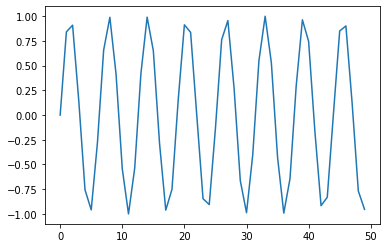

In [10]:
import math
from matplotlib import pyplot as plt
import numpy as np

size=200
std=0
sin_wave = np.array([math.sin(x) for x in np.arange(size)]+np.random.normal(0,std,size))
plt.plot(sin_wave[:50])

# train data
X = []
Y = []


seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)
Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)
print(X.shape,Y.shape)




In [11]:
# validation data
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)
Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)
print(X_val.shape,Y_val.shape)

(50, 50, 1) (50, 1)


In [12]:
# Create the Architecture for our RNN model
learning_rate = 0.0001    
nepoch = 25               
T = 50                   # length of sequence
hidden_dim = 100         
output_dim = 1
bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

# weights
U = np.random.uniform(0, 1, (hidden_dim, T))            # matrix for weights between input and hidden layers
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))   # matrix for shared weights in the RNN layer (hidden layer)
V = np.random.uniform(0, 1, (output_dim, hidden_dim))   # matrix for weights between hidden and output layers

# activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


TRAIN THE MODEL (via BPTT)
Now that we have defined our model, we can finally move on with training it on our sequence data. We can subdivide the training process into smaller steps, namely:

- Step 2.1 : Check the loss on training data
- Step 2.1.1 : Forward Pass
- Step 2.1.2 : Calculate Error
- Step 2.2 : Check the loss on validation data
- Step 2.2.1 : Forward Pass
- Step 2.2.2 : Calculate Error
- Step 2.3 : Start actual training
- Step 2.3.1 : Forward Pass
- Step 2.3.2 : Backpropagate Error
- Step 2.3.3 : Update weights

We need to repeat these steps until convergence. If the model starts to overfit, stop! Or simply pre-define the number of epochs.

In [13]:
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0
    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])

    # check loss on val
    val_loss = 0.0
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
    val_loss = val_loss / float(y.shape[0])

    print(f'Epoch: {epoch + 1}, Loss: {loss}, Val Loss: {val_loss}')

   # train model
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s

        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t
            
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch: 1, Loss: [[141187.37926625]], Val Loss: [[70591.60030032]]
Epoch: 2, Loss: [[93053.12452982]], Val Loss: [[46524.85870616]]
Epoch: 3, Loss: [[54918.86979312]], Val Loss: [[27458.11711187]]
Epoch: 4, Loss: [[26784.61238094]], Val Loss: [[13391.37417711]]
Epoch: 5, Loss: [[8636.34395147]], Val Loss: [[4317.60856171]]
Epoch: 6, Loss: [[434.10264355]], Val Loss: [[216.82198737]]
Epoch: 7, Loss: [[29.96168117]], Val Loss: [[14.95673179]]
Epoch: 8, Loss: [[30.16326377]], Val Loss: [[15.05624921]]
Epoch: 9, Loss: [[29.85313344]], Val Loss: [[14.90014699]]
Epoch: 10, Loss: [[29.87461674]], Val Loss: [[14.91056666]]
Epoch: 11, Loss: [[30.10096001]], Val Loss: [[15.0273311]]
Epoch: 12, Loss: [[30.02888604]], Val Loss: [[14.98543001]]
Epoch: 13, Loss: [[29.80109216]], Val Loss: [[14.87322276]]
Epoch: 14, Loss: [[30.28858253]], Val Loss: [[15.11638707]]
Epoch: 15, Loss: [[30.48057465]], Val Loss: [[15.21371741]]
Epoch: 16, Loss: [[29.96652229]], Val Loss: [[14.95980888]]
Epoch: 17, Loss: [[

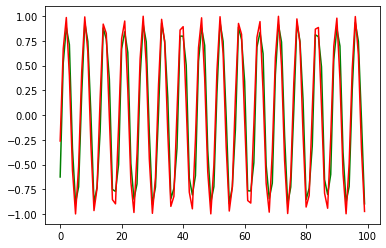

0.1002022289212415

In [14]:
## GET PREDICTIONS
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(Y_val[:, 0], preds[T:, 0, 0]))